In [1]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import random
import os
import logmelspectr_params as params
import pandas as pd
import numpy as np
import itertools


In [2]:
tf.__version__

'2.2.0'

checkpoint_path='/nas/home/cborrelli/tripletloss_bot/checkpoints/vggish/vggish_model.ckpt'

import os

reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)
var_to_shape_map = reader.get_variable_to_shape_map()

for key in var_to_shape_map:
    print("tensor_name: ", key)
    print(reader.get_tensor(key).shape) # Remove this is you want to print only variable names

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=-1, keepdims=True), K.epsilon()))

In [6]:
def get_base_model(input_shape):

    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
    
    # Block fc
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1_1')(x)
    x = Dense(4096, activation='relu', name='fc1_2')(x)
    
    model = Model(img_input, x, name='vggish')
    return model

In [7]:
def get_head_model(embedding_shape):
    embedding_l = Input(embedding_shape, name='embed_ref')
    embedding_r = Input(embedding_shape, name='embed_dif')
    lambda_layer  = Lambda(euclidean_distance)([embedding_l, embedding_r])
    model = Model([embedding_l, embedding_r], lambda_layer, name='distance')
    
    return model

### Create siamese network

In [8]:
def create_siamese_network(input_shape, 
                           checkpoint_path='/nas/home/cborrelli/tripletloss_bot/checkpoints/vggish/vggish_model.ckpt'):
    """
    Create the siamese model structure using the supplied base and head model.
    """
    input_ref = Input(input_shape, name="input_ref") # reference track
    input_dif = Input(input_shape, name="input_dif") # different track

    base_model = get_base_model(input_shape)
    
    
    # Initialize base model with VGGish weights
    reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)
    var_to_shape_map = reader.get_variable_to_shape_map()

    tensor_layers_list = []
    for key in var_to_shape_map:    
        tensor_layers_list.append('/'.join(key.split('/')[:-1]))

    for index, t in enumerate(tensor_layers_list):
        weights_key = t + '/weights'
        bias_key = t + '/biases'
        weights = reader.get_tensor(weights_key)
        biases = reader.get_tensor(bias_key)

        keras_layer_name = t.split('/')[-1]
        if keras_layer_name=='logits' or keras_layer_name == 'fc2':
            continue
  
        base_model.get_layer(keras_layer_name).set_weights([weights, biases])


    
    processed_ref = base_model(input_ref)
    processed_dif = base_model(input_dif)

    head_model = get_head_model(base_model.output_shape[-1])
    head = head_model([processed_ref, processed_dif])

    siamese_model = Model([input_ref, input_dif], head)
    return siamese_model

In [9]:
model = create_siamese_network(input_shape=(96, 64, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          [(None, 96, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_dif (InputLayer)          [(None, 96, 64, 1)]  0                                            
__________________________________________________________________________________________________
vggish (Model)                  (None, 4096)         71616768    input_ref[0][0]                  
                                                                 input_dif[0][0]                  
__________________________________________________________________________________________________
distance (Model)                (None, 1)            0           vggish[1][0]                 

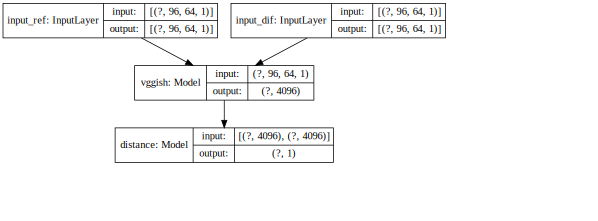

In [10]:
from IPython.display       import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, 
                 show_shapes      = True, 
                 show_layer_names = True).create(prog='dot', format='svg'))

### Define loss

In [ ]:
# https://gombru.github.io/2019/04/03/ranking_loss/
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + (y_true) * K.square(K.maximum(margin - y_pred, 0)))



### Data loader

In [ ]:
def frame(data, window_length, hop_length):
    """Convert array into a sequence of successive possibly overlapping frames.
    An n-dimensional array of shape (num_samples, ...) is converted into an
    (n+1)-D array of shape (num_frames, window_length, ...), where each frame
    starts hop_length points after the preceding one.
    This is accomplished using stride_tricks, so the original data is not
    copied.  However, there is no zero-padding, so any incomplete frames at the
    end are not included.
    Args:
    data: np.array of dimension N >= 1.
    window_length: Number of samples in each frame.
    hop_length: Advance (in samples) between each window.
    Returns:
    (N+1)-D np.array with as many rows as there are complete frames that can be
    extracted.
    """
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    result = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
    return result

class TrainDataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, dataframe, feature_path, batch_size=32, dim=(96, 64), n_channels=1,
                  shuffle=True, classes_list=['-', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06'],
                num_batch_epoch=100):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.classes_list = classes_list
        self.n_channels = n_channels
        self.len = num_batch_epoch
        self.feature_path = feature_path

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.len
    
    def __getitem__(self, batch_index):
        'Generate one batch of data'        
        negative_couples_classes = np.array(list(itertools.combinations(self.classes_list, r=2)))
        positive_couples_classes = np.array(list(zip(self.classes_list, self.classes_list)))

        negative_selected_pairs = negative_couples_classes[np.random.choice(negative_couples_classes.shape[0], 
                                                            self.batch_size // 2, replace=True), :]
        positive_selected_pairs = positive_couples_classes[np.random.choice(positive_couples_classes.shape[0], 
                                                            self.batch_size // 2, replace=True), :]

        selected_pairs = np.concatenate((positive_selected_pairs, negative_selected_pairs), axis=0)

        y = np.concatenate((np.zeros((self.batch_size//2)), np.ones((self.batch_size//2))), axis=0)

        features_sample_rate = 1.0 / params.STFT_HOP_LENGTH_SECONDS

        example_window_length = int(round(
            params.EXAMPLE_WINDOW_SECONDS * features_sample_rate))
        example_hop_length = int(round(
            params.EXAMPLE_HOP_SECONDS * features_sample_rate))

        X_0 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X_1 = np.empty((self.batch_size, *self.dim, self.n_channels))

        for sample_batch_index, pairs in enumerate(selected_pairs):

            sample = np.empty((2, *self.dim, self.n_channels))
            for a, alg in enumerate(pairs):
                row = self.dataframe[self.dataframe.system_id == alg].sample(n=1)
                log_mel = np.load(os.path.join(self.feature_path, row['audio_filename'].values[0] + '.npy'))
                log_mel = log_mel.transpose()

                if log_mel.shape[0] < self.dim[0]:
                    pad_len = self.dim[0] - log_mel.shape[0] + 1
                    log_mel = np.pad(log_mel, ((0, pad_len), (0, 0)))

                log_mel = frame(log_mel, example_window_length, example_hop_length)

                selected_frame = np.random.randint(low=0, high=log_mel.shape[0], size=1)

                selected_log_mel = log_mel[selected_frame, :, :]
                selected_log_mel = selected_log_mel[0,:, :, np.newaxis]

                sample[a] = selected_log_mel

            X_0[sample_batch_index] = sample[0]            
            X_1[sample_batch_index] = sample[1]            


        return [X_0, X_1], y

    
    
class TestDataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, dataframe, feature_path, batch_size=32, dim=(96, 64), n_channels=1,
                  shuffle=True, classes_pair=['-', '-'],
                num_batch_epoch=100):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.n_channels = n_channels
        self.len = num_batch_epoch
        self.feature_path = feature_path
        self.classes_pair = classes_pair

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.len
    
    def __getitem__(self, batch_index):
        'Generate one batch of data'        

            # If i am specifying only one element it means I want to use the data generator for testing
            # only one class
        
        selected_pairs =  [self.classes_pair] * self.batch_size
        features_sample_rate = 1.0 / params.STFT_HOP_LENGTH_SECONDS
        example_window_length = int(round(
            params.EXAMPLE_WINDOW_SECONDS * features_sample_rate))
        example_hop_length = int(round(
            params.EXAMPLE_HOP_SECONDS * features_sample_rate))

        X_0 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        if self.classes_pair[0] == self.classes_pair[1]:
            y = np.zeros((self.batch_size))
        else:
            y = np.ones((self.batch_size))
            
        for sample_batch_index, pairs in enumerate(selected_pairs):

            sample = np.empty((2, *self.dim, self.n_channels))
            for a, alg in enumerate(pairs):
                row = self.dataframe[self.dataframe.system_id == alg].sample(n=1)
                log_mel = np.load(os.path.join(self.feature_path, row['audio_filename'].values[0] + '.npy'))
                log_mel = log_mel.transpose()

                if log_mel.shape[0] < self.dim[0]:
                    pad_len = self.dim[0] - log_mel.shape[0] + 1
                    log_mel = np.pad(log_mel, ((0, pad_len), (0, 0)))

                log_mel = frame(log_mel, example_window_length, example_hop_length)

                selected_frame = np.random.randint(low=0, high=log_mel.shape[0], size=1)

                selected_log_mel = log_mel[selected_frame, :, :]
                selected_log_mel = selected_log_mel[0,:, :, np.newaxis]

                sample[a] = selected_log_mel

            X_0[sample_batch_index] = sample[0]            
            X_1[sample_batch_index] = sample[1]   
            
            


        return [X_0, X_1], y

### Load dataframes

In [ ]:
train_txt_path = "/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
train_feat_root = "/nas/home/cborrelli/tripletloss_bot/features/logmelspectr/train"
df_train = pd.read_csv(train_txt_path, sep=" ", header=None)
df_train.columns = ["speaker_id", "audio_filename", "null", "system_id", "label"]
df_train = df_train.drop(columns="null")

dev_txt_path = "/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
dev_feat_root = "/nas/home/cborrelli/tripletloss_bot/features/logmelspectr/dev"
df_dev = pd.read_csv(dev_txt_path, sep=" ", header=None)
df_dev.columns = ["speaker_id", "audio_filename", "null", "system_id", "label"]
df_dev = df_dev.drop(columns="null")

### Train model

In [ ]:
epochs = 1
steps_per_epoch = 15


train_classes_list = ['-', 'A01', 'A02', 'A03']

train_generator = TrainDataGenerator(dataframe=df_train, feature_path=train_feat_root,
                                     classes_list=train_classes_list, num_batch_epoch=steps_per_epoch)
val_generator = TrainDataGenerator(dataframe=df_dev, feature_path=dev_feat_root, classes_list=train_classes_list,
                                   num_batch_epoch=steps_per_epoch)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='/nas/home/cborrelli/tripletloss_bot/checkpoints/siamese'),
]
## add callback
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=contrastive_loss, optimizer=opt)

history = model.fit(train_generator, validation_data=val_generator,
                    epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=my_callbacks)

### Check that save model is working

In [ ]:
epochs = 1
steps_per_epoch = 15


train_classes_list = ['-', 'A01', 'A02', 'A03']

train_generator = TrainDataGenerator(dataframe=df_train, feature_path=train_feat_root, batch_size=1,
                                     classes_list=train_classes_list, num_batch_epoch=steps_per_epoch)
val_generator = TrainDataGenerator(dataframe=df_dev, feature_path=dev_feat_root, classes_list=train_classes_list,
                                   batch_size=1,
                                   num_batch_epoch=steps_per_epoch)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='/nas/home/cborrelli/tripletloss_bot/checkpoints/siamese'),
]
## add callback
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=contrastive_loss, optimizer=opt)

history = model.fit(train_generator, validation_data=val_generator,
                    epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=my_callbacks)

In [ ]:
train_generator = TrainDataGenerator(dataframe=df_train, feature_path=train_feat_root, batch_size=1,
                                     classes_list=train_classes_list, num_batch_epoch=steps_per_epoch)